In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
torch.set_grad_enabled(True)

In [2]:
def get_num_corrects(preds, labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
class Network(nn.Module): # 输入尺寸28*28
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12,kernel_size=5)
        
        self.fc1 = nn.Linear(in_features = 12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        #(1) hidden conv1 layer
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        #(2) hidden conv2 layer
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        #(3) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        
        #(4) hidden linear layer
        t = F.relu(self.fc2(t))
        
        #(5) output layer
        t = self.out(t)
        t = F.softmax(t, dim = 1)
        return t

## 1.1 单个样本预测

In [5]:
network = Network()

In [6]:
sample = next(iter(train_set))

In [7]:
image, label = sample
image.shape

torch.Size([1, 28, 28])

In [8]:
image.unsqueeze(dim = 0).shape # unsqueeze不共享原始数据内存 并且这里用unsqueeze是因为nn.conv函数的维度要求

torch.Size([1, 1, 28, 28])

In [9]:
image.shape

torch.Size([1, 28, 28])

In [10]:
pred = network.forward(image.unsqueeze(dim = 0))

In [11]:
pred # 可以看到以下的概率都是接近与10%的，说明这确实是一个分布均匀的数据集

tensor([[0.0913, 0.0938, 0.0997, 0.1015, 0.0947, 0.1041, 0.1030, 0.0940, 0.1120,
         0.1057]], grad_fn=<SoftmaxBackward>)

In [12]:
print(pred.argmax(dim = 1))
print(label)

tensor([8])
9


In [13]:
pred.sum() # 结果确实等于1

tensor(1.0000, grad_fn=<SumBackward0>)

## 1.2 批样本预测

In [14]:
data_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = 10
)

batch = next(iter(data_loader))

In [15]:
images, labels = batch
images.shape

torch.Size([10, 1, 28, 28])

In [16]:
preds = network(images)

In [17]:
preds

tensor([[0.0913, 0.0938, 0.0997, 0.1015, 0.0947, 0.1041, 0.1030, 0.0940, 0.1120,
         0.1057],
        [0.0917, 0.0939, 0.0993, 0.1014, 0.0948, 0.1048, 0.1025, 0.0940, 0.1118,
         0.1058],
        [0.0915, 0.0937, 0.0996, 0.1015, 0.0945, 0.1046, 0.1027, 0.0942, 0.1121,
         0.1055],
        [0.0914, 0.0937, 0.0996, 0.1016, 0.0946, 0.1046, 0.1029, 0.0943, 0.1120,
         0.1054],
        [0.0914, 0.0940, 0.1004, 0.1007, 0.0950, 0.1043, 0.1028, 0.0937, 0.1120,
         0.1058],
        [0.0913, 0.0936, 0.0997, 0.1016, 0.0946, 0.1047, 0.1027, 0.0941, 0.1120,
         0.1057],
        [0.0915, 0.0935, 0.1003, 0.1012, 0.0946, 0.1040, 0.1027, 0.0940, 0.1124,
         0.1057],
        [0.0914, 0.0938, 0.0995, 0.1018, 0.0945, 0.1047, 0.1028, 0.0943, 0.1117,
         0.1055],
        [0.0918, 0.0942, 0.1000, 0.1017, 0.0948, 0.1043, 0.1029, 0.0941, 0.1116,
         0.1046],
        [0.0920, 0.0937, 0.1002, 0.1015, 0.0950, 0.1041, 0.1031, 0.0939, 0.1118,
         0.1047]], grad_fn=<

In [18]:
preds.argmax(dim = 1)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [19]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [20]:
preds.argmax(dim = 1).eq(labels).sum().item() # 显示预测正确的数量

0

## 2. 训练网络

In [21]:
network = Network()

In [22]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
batch = next(iter(train_loader))
images, labels = batch

## 2.1 计算误差

In [23]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item()

2.303607702255249

## 2.2 计算梯度

In [24]:
print(network.conv1.weight.grad)

None


In [25]:
loss.backward()

In [26]:
network.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

## 3. 优化网络

In [27]:
optimizer = optim.Adam(network.parameters(), lr = 0.01)

In [28]:
loss.item()

2.303607702255249

In [29]:
get_num_corrects(preds, labels)

9

In [30]:
optimizer.step() # 更新权重

In [31]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item()

2.2998874187469482

In [32]:
get_num_corrects(preds, labels)

14

## 4. 完整的一个epoch训练

In [33]:
network = Network() 

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle = True)
optimizer = optim.Adam(network.parameters(), lr = 0.001)

for epoch in range(5):
    total_correct = 0.
    total_loss = 0
    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_corrects(preds, labels)
    print("Epoch %d: Accuracy: %.2f loss:%.2f" %(epoch + 1, total_correct / len(train_set), total_loss))

Epoch 1: Accuracy: 0.57 loss:1138.83
Epoch 2: Accuracy: 0.63 loss:1098.64
Epoch 3: Accuracy: 0.65 loss:1084.92
Epoch 4: Accuracy: 0.67 loss:1073.22
Epoch 5: Accuracy: 0.68 loss:1067.15


## 5. 利用结果生成混淆矩阵

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [6]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds),
            dim = 0
        )
    return all_preds

In [36]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 1000)
train_preds = get_all_preds(network, prediction_loader)

In [37]:
train_preds.shape

torch.Size([60000, 10])

In [38]:
train_preds.requires_grad

True

In [39]:
train_preds.grad # 显然没有梯度

In [40]:
train_preds.grad_fn

## 5.1 局部关闭梯度的方法

In [41]:
with torch.no_grad(): 
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 1000)
    train_preds = get_all_preds(network, prediction_loader)
#或者使用 @torch.no_grad()    

In [42]:
print(train_preds.requires_grad)

False


In [43]:
preds_correct = get_num_corrects(train_preds, train_set.targets)

print("accuracy: %.2f%%" %(preds_correct * 100 / len(train_set)))

accuracy: 68.17%


In [44]:
# stack和cat的区别在于，staack沿着不存在的新轴堆叠，而cat沿已经存在的轴堆叠
# train_set.targets的维度显然是60000，所以不存在第二个轴，用stack比较合适，自动创建并堆叠第二个轴
stacked = torch.stack( 
    (
        train_set.targets,
        train_preds.argmax(dim = 1)
    ),
    dim = 1
)

In [45]:
train_set.targets.shape

torch.Size([60000])

In [46]:
stacked.shape

torch.Size([60000, 2])

In [47]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [48]:
stacked[0].tolist()

[9, 9]

## 5.2 创建混淆矩阵

In [49]:
cmt = torch.zeros(10, 10, dtype = torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [50]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [51]:
cmt

tensor([[5484,    0,  144,  119,    0,    5,  180,    0,   68,    0],
        [2646,    0,  178, 3159,    0,    1,    5,    0,   11,    0],
        [ 106,    0, 5189,   62,    0,    0,  599,    0,   44,    0],
        [ 621,    0,   41, 5151,    0,    4,  155,    0,   28,    0],
        [ 248,    0, 3567,  831,    0,    1, 1313,    0,   39,    1],
        [   1,    0,    4,    1,    0, 5632,    1,  114,   50,  197],
        [1748,    0, 1165,  192,    0,    0, 2767,    0,  127,    1],
        [   0,    0,    0,    0,    0,  297,    1, 5061,   80,  561],
        [  78,    0,  117,   20,    0,    7,   41,    4, 5726,    7],
        [   0,    0,    1,    1,    0,   25,    0,   74,    6, 5893]],
       dtype=torch.int32)

### 其实也可以用库函数直接生成混淆矩阵

In [52]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim = 1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5484,    0,  144,  119,    0,    5,  180,    0,   68,    0],
       [2646,    0,  178, 3159,    0,    1,    5,    0,   11,    0],
       [ 106,    0, 5189,   62,    0,    0,  599,    0,   44,    0],
       [ 621,    0,   41, 5151,    0,    4,  155,    0,   28,    0],
       [ 248,    0, 3567,  831,    0,    1, 1313,    0,   39,    1],
       [   1,    0,    4,    1,    0, 5632,    1,  114,   50,  197],
       [1748,    0, 1165,  192,    0,    0, 2767,    0,  127,    1],
       [   0,    0,    0,    0,    0,  297,    1, 5061,   80,  561],
       [  78,    0,  117,   20,    0,    7,   41,    4, 5726,    7],
       [   0,    0,    1,    1,    0,   25,    0,   74,    6, 5893]],
      dtype=int64)

### 画图函数 可直接略过

In [53]:
def plot_confusion_matrix(cm, classes, 
                          normalize = False,
                          title = "Confusion Matrix",
                          cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_masks = np.arange(len(classes))
    plt.xticks(tick_masks, classes, rotation =45)
    plt.yticks(tick_masks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    

Confusion matrix, without normalization
tensor([[5484,    0,  144,  119,    0,    5,  180,    0,   68,    0],
        [2646,    0,  178, 3159,    0,    1,    5,    0,   11,    0],
        [ 106,    0, 5189,   62,    0,    0,  599,    0,   44,    0],
        [ 621,    0,   41, 5151,    0,    4,  155,    0,   28,    0],
        [ 248,    0, 3567,  831,    0,    1, 1313,    0,   39,    1],
        [   1,    0,    4,    1,    0, 5632,    1,  114,   50,  197],
        [1748,    0, 1165,  192,    0,    0, 2767,    0,  127,    1],
        [   0,    0,    0,    0,    0,  297,    1, 5061,   80,  561],
        [  78,    0,  117,   20,    0,    7,   41,    4, 5726,    7],
        [   0,    0,    1,    1,    0,   25,    0,   74,    6, 5893]],
       dtype=torch.int32)


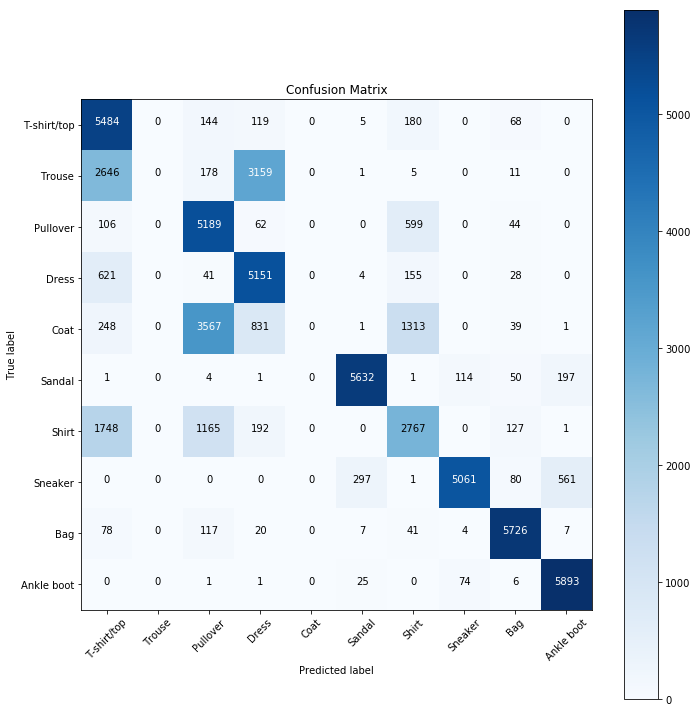

In [54]:
names = ('T-shirt/top', 'Trouse', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cmt, names)

## 6.1 使用TensorBoard分析模型

In [55]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
optimizer = optim.Adam(network.parameters(), lr = 0.001)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb = SummaryWriter()
tb.add_image('images', grid)
tb.add_graph(network, images)


for epoch in range(10):
    total_loss = 0
    total_correct = 0
    
    for bach in train_loader:
        images, labels = batch
        
        preds = network(images)
        loss = F.cross_entropy(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += get_num_corrects(preds, labels)
        
    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)
    
    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
    
    print('Epoch: %d Accuracy: %.4f Loss: %.4f' %(epoch + 1, total_correct / len(train_set), total_loss))
tb.close()

Epoch: 1 Accuracy: 0.7258 Loss: 1043.0020
Epoch: 2 Accuracy: 0.7716 Loss: 1012.2997
Epoch: 3 Accuracy: 0.7734 Loss: 1010.6215
Epoch: 4 Accuracy: 0.7900 Loss: 1000.6771
Epoch: 5 Accuracy: 0.7900 Loss: 1000.6237
Epoch: 6 Accuracy: 0.7900 Loss: 1000.4481
Epoch: 7 Accuracy: 0.7900 Loss: 1000.1734
Epoch: 8 Accuracy: 0.7900 Loss: 999.9886
Epoch: 9 Accuracy: 0.7960 Loss: 997.2240
Epoch: 10 Accuracy: 0.8200 Loss: 982.5974


* 完成后以上步骤后，在代码目录下输入命令`tensorboard --logdir=runs`,进入端口localhost:6006即可看到结果

## 6.2 利用TensorBoard测试多种超参数

In [4]:
from itertools import product

In [5]:
parameters = dict(
    lr = [.01, .001],
    batch_size = [10, 100, 1000],
    shuffle = [True, False]
)

In [6]:
param_values = [v for v in parameters.values()]
param_values

[[0.01, 0.001], [10, 100, 1000], [True, False]]

In [12]:
for lr, batch_size, shuffle in product(*param_values):
    print(lr, batch_size, shuffle)

0.01 10 True
0.01 10 False
0.01 100 True
0.01 100 False
0.01 1000 True
0.01 1000 False
0.001 10 True
0.001 10 False
0.001 100 True
0.001 100 False
0.001 1000 True
0.001 1000 False


In [18]:
for lr, batch_size, shuffle in product(*param_values):
    network = Network()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = shuffle)
    optimizer = optim.Adam(network.parameters(), lr = lr)

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)+
    
    comment = f' batch_size={batch_size} lr={lr} shuffle={shuffle}'
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(network, images)
    for epoch in range(10):
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += get_num_corrects(preds, labels)

        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

        #tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
        #tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
        #tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
        
        for name, weight in network.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)
        
    tb.close()

## 6.3 利用Run Builder更自由地组合多种超参数

In [2]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

In [8]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs

In [9]:
parameters = dict(
    lr = [.01, .001],
    batch_size = [10, 100, 1000],
    shuffle = [True, False]
)

In [10]:
runs = RunBuilder.get_runs(parameters)
runs

[Run(lr=0.01, batch_size=10, shuffle=True),
 Run(lr=0.01, batch_size=10, shuffle=False),
 Run(lr=0.01, batch_size=100, shuffle=True),
 Run(lr=0.01, batch_size=100, shuffle=False),
 Run(lr=0.01, batch_size=1000, shuffle=True),
 Run(lr=0.01, batch_size=1000, shuffle=False),
 Run(lr=0.001, batch_size=10, shuffle=True),
 Run(lr=0.001, batch_size=10, shuffle=False),
 Run(lr=0.001, batch_size=100, shuffle=True),
 Run(lr=0.001, batch_size=100, shuffle=False),
 Run(lr=0.001, batch_size=1000, shuffle=True),
 Run(lr=0.001, batch_size=1000, shuffle=False)]

## 将以上代码嵌入到之前的网络中

In [27]:
for run in RunBuilder.get_runs(parameters):
    comment = f' -{run}'
    lr, batch_size, shuffle = run
    # Training process given the set of parameters

0.01 10 True
0.01 10 False
0.01 100 True
0.01 100 False
0.01 1000 True
0.01 1000 False
0.001 10 True
0.001 10 False
0.001 100 True
0.001 100 False
0.001 1000 True
0.001 1000 False
